# Car Price Prediction 

***
_**Importing the required libraries & packages**_


In [1]:
import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import pickle 
import warnings
warnings.filterwarnings('ignore')

_**Changing The Default Working Directory Path & Reading the Dataset using Pandas Command**_

In [2]:
os.chdir('C:\\Users\\Shridhar\\Desktop\\DS Project')
df = pd.read_csv('dataset.csv')

## Data Cleaning

_**Viewing the dataset for identifying the unwanted columns**_

In [3]:
df.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


_**Dropping the `Unnamed: 0`, `Location` and `New_Price` column since it is not much important for the prediction**_

In [4]:
df.drop(['Unnamed: 0','Location','New_Price'],axis = 1,inplace = True)

_**Checking for the null values in the dataset**_

In [5]:
df.isna().sum()

Name                  0
Year                  0
Kilometers_Driven     0
Fuel_Type             0
Transmission          0
Owner_Type            0
Mileage               2
Engine               36
Power                36
Seats                42
Price                 0
dtype: int64

_**There are several cars in the dataset, some of them with a count higher than 1. Sometimes the resale value of a car also depends on manufacturer of the car.So, here extracting the manufacturer name from this column and adding it to the dataset**_

In [6]:
Manfacturer = df['Name'].str.split(" ",expand = True)
df['Manfacturer'] = Manfacturer[0]

_**The `Year` column from the dataset has no significance on its own so calculating the years of cars used till now and adding it to the dataset.**_

In [7]:
curr_time = datetime.datetime.now()
df['Years Used'] = df['Year'].apply(lambda x : curr_time.year - x)

_**Dropping the `Name` and `Year` column since the needed data is extracted from it and added to the dataset in seperate columns as `Manfacturer` and `Years Used`**_

In [8]:
df.drop(['Name','Year'],axis = 1,inplace = True)

_**The `Mileage` column defines the mileage of the car which affects the price of the car during the sales.So that extracting the numerical values from the `Mileage` column and since it has missing values, filling out the missing values with the mean & modifying the column with the values**_

In [9]:
Mileage = df['Mileage'].str.split(" ",expand = True)
df['Mileage'] = pd.to_numeric(Mileage[0],errors = 'coerce')
df['Mileage'].fillna(df['Mileage'].astype('float').mean(),inplace = True)

_**The `Engine` column has the CC of the car which affects the price of the car during the sales.So that removing CC and  extracting the numerical values from the `Engine` column and since it has missing values, filling out the missing values with the mean & modifying the column with the values**_

In [10]:
Engine = df['Engine'].str.split(" ",expand = True)
df['Engine'] = pd.to_numeric(Engine[0],errors = 'coerce')
df['Engine'].fillna(df['Engine'].astype('float').mean(),inplace = True)

_**The `Power` column has the bhp of the car which affects the price of the car during the sales.So that removing bhp and  extracting the numerical values from the `Power` column and since it has missing values, filling out the missing values with the mean & modifying the column with the values**_

In [11]:
Power = df['Power'].str.split(" ",expand = True)
df['Power'] = pd.to_numeric(Power[0],errors = 'coerce')
df['Power'].fillna(df['Power'].astype('float').mean(),inplace = True)

_**Since the `Seats` column has some missing values, filling out the missing values with the mean values of the same column**_

In [12]:
df['Seats'].fillna(df['Seats'].astype('float').mean(),inplace = True)

_**After filling out the missing value with the appropriate values, checking for the null values in the dataset**_

In [13]:
df.isna().sum()

Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
Manfacturer          0
Years Used           0
dtype: int64

## Data Visualization

_**Plotting the Bar Graph with count of cars based on the `Manfacturer` and confirm that there are no null values and identify all unique values from the `Manfacturer` and saving the PNG File**_

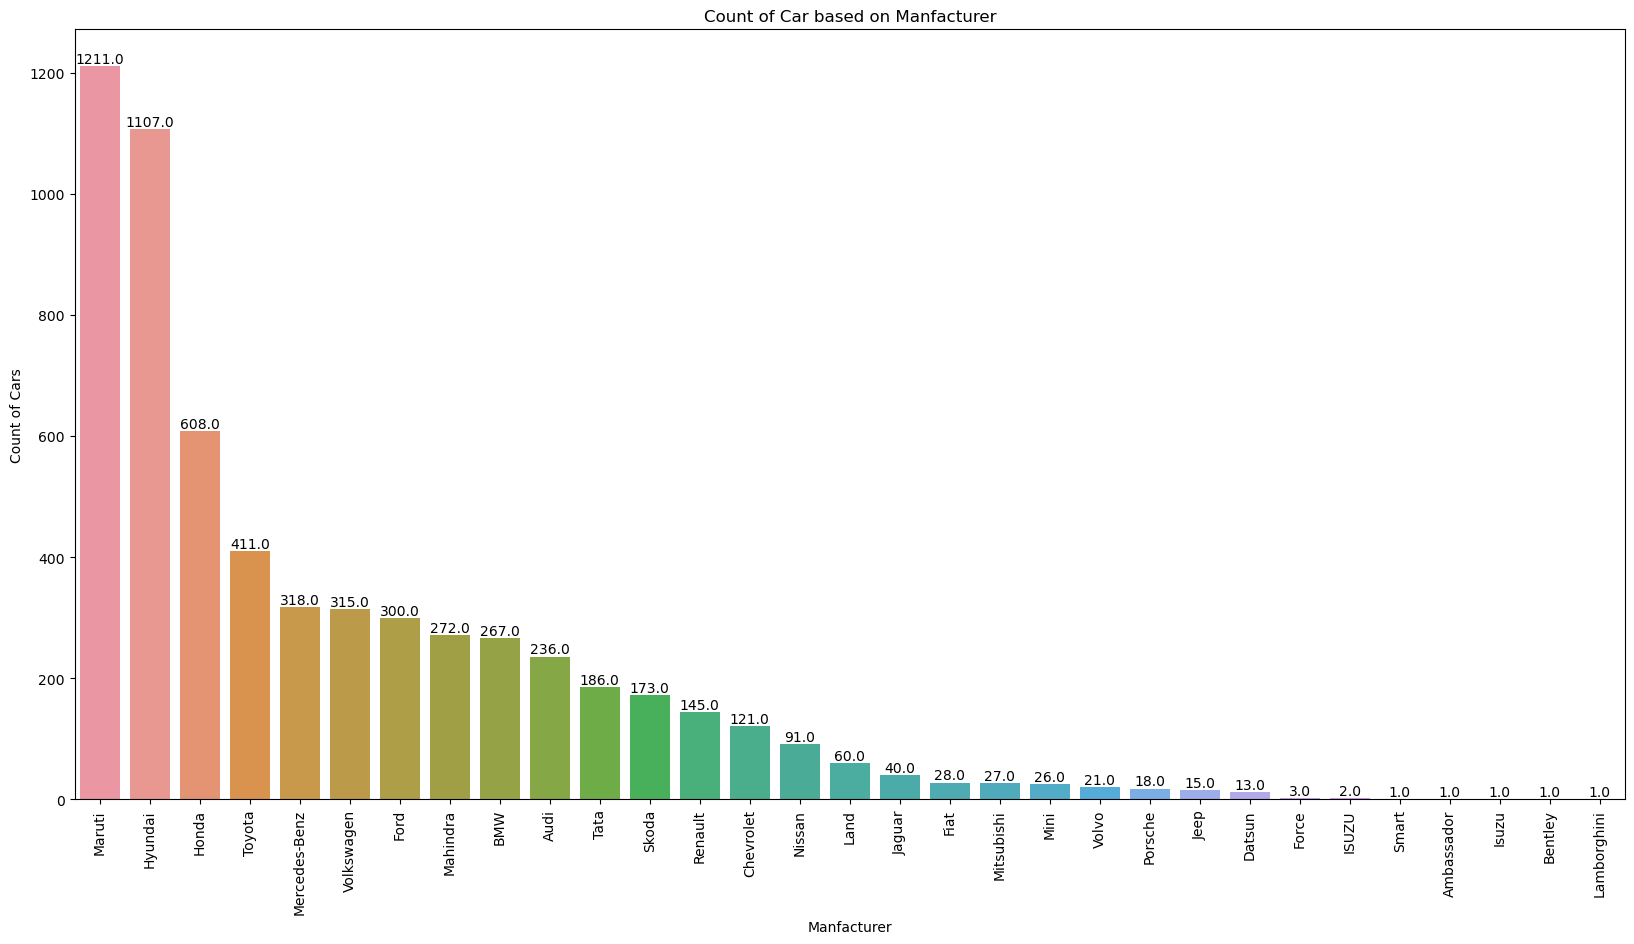

In [14]:
plt.rcParams['figure.figsize'] = 20,10
Cars = df['Manfacturer'].value_counts()
plot = sns.barplot(x = Cars.index,y = Cars.values,data = df)
plt.xticks(rotation = 90)
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.title('Count of Car based on Manfacturer')
plt.xlabel('Manfacturer')
plt.ylabel('Count of Cars')
plt.savefig('Count of Cars.png')
plt.show()

_**Getting the Correlation Values from all the numeric columns from the dataset using Seaborn Heatmap & saving the PNG File**_

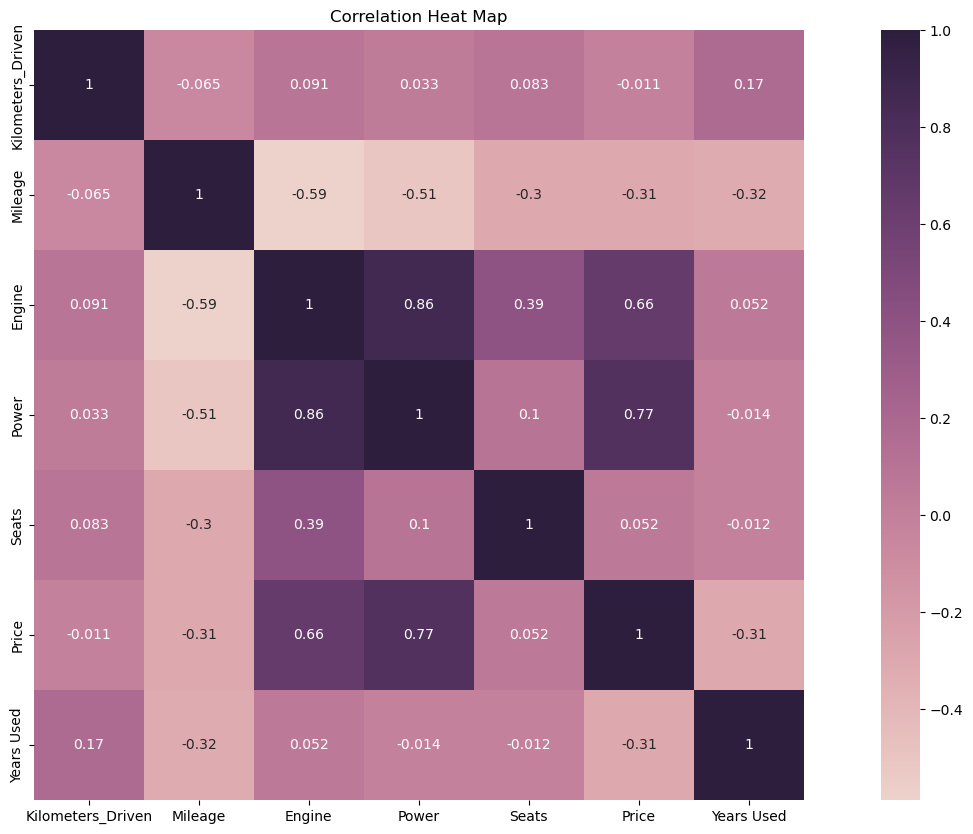

In [15]:
sns.heatmap(df.corr(),cmap = sns.cubehelix_palette(as_cmap = True),annot = True, cbar = True,square = True)
plt.title('Correlation Heat Map')
plt.savefig('Correlation Heat Map.png')
plt.show()

_**Assigning the dependent and independent variable**_

In [16]:
x = df.drop(['Price'],axis = 1)
y = df['Price']

## Data Preprocessing

_**Splitting the dependent variable & independent variable into training and test dataset using train test split**_

In [17]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state = 45)

_**Creating the dummy columns for all the categorical columns such as `Manfacturer`, `Fuel_Type`,
`Transmission`, `Owner_Type` in the training independent dataset and getting the dimensions of the training independent dataset for cross-check**_

In [18]:
x_train = pd.get_dummies(x_train,columns = ['Manfacturer', 'Fuel_Type', 'Transmission', 'Owner_Type'],drop_first = True)
print(x_train.shape)

(4213, 42)


_**Similarly, creating the dummy columns for all the categorical columns such as `Manfacturer`, `Fuel_Type`,
`Transmission`, `Owner_Type` in the test independent dataset and getting the dimensions of the test independent dataset for cross-check**_

In [19]:
x_test = pd.get_dummies(x_test,columns = ['Manfacturer', 'Fuel_Type', 'Transmission', 'Owner_Type'],drop_first = True)
print(x_test.shape)

(1806, 38)


_**By the dimensional checking its so evident that the dummy column creation is different in training and test independent data. So that filling in all the missing columns of test independent data with 0**_

In [20]:
miss_col = set(x_train.columns) - set(x_test.columns)
for col in miss_col:
    x_test[col] = 0
x_test = x_test[x_train.columns]

_**Now after processing, the dimensions of the column of both training and test independent data are same**_

In [21]:
print(x_train.shape)
print(x_test.shape)

(4213, 42)
(1806, 42)


_**Standardizing the independent training variable and independent test variable of the dataset**_

In [22]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)

## Model Fitting

_**Defining the Function for the ML algorithms using GridSearchCV Algorithm and Predicting the Dependent Variable by fitting the given model and create the pickle file of the model with the given Algo_name. Further getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format, Mean Absolute error and Root Mean Squared error between the predicted values and dependent test dataset**_

In [23]:
def FitModel(x,y,algo_name,algorithm,GridSearchParams,cv):
    np.random.seed(10)
    grid = GridSearchCV(estimator = algorithm, param_grid = GridSearchParams, cv = cv,
                       scoring = 'r2', verbose = 0,n_jobs = -1)
    grid_result = grid.fit(x_train,y_train)
    pred = grid_result.predict(x_test)
    best_params = grid_result.best_params_
    pickle.dump(grid_result,open(algo_name,'wb'))
    print('Algorithm Name : ',algo_name,'\n')
    print('Best Params : ',best_params,'\n')
    print('Percentage of R2 Score : {} %'.format(100 * r2_score(y_test,pred)),'\n')
    print('Mean Absolute Error : ',mean_absolute_error(y_test,pred),'\n')
    print('Root Mean Squared Error : ',sqrt(mean_squared_error(y_test,pred)),'\n')

_**Running the function with empty parameters since the Linear Regression model doesn't need any special parameters and fitting the Linear Regression Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format ,Mean Absolute error and Root Mean Squared error between the predicted values and dependent test dataset and also the pickle file with the name Linear Regression.**_

In [24]:
param = {}
FitModel(x,y,'Linear Regression',LinearRegression(),param,cv = 10)

Algorithm Name :  Linear Regression 

Best Params :  {} 

Percentage of R2 Score : 76.90457787320157 % 

Mean Absolute Error :  2.968897995521326 

Root Mean Squared Error :  5.354109129131152 



_**Running the function with empty parameters since the Lasso model doesn't need any special parameters and fitting the Lasso Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format ,Mean Absolute error and Root Mean Squared error between the predicted values and dependent test dataset and also the pickle file with the name Lasso.**_

In [25]:
FitModel(x,y,'Lasso',Lasso(),param,cv = 10)

Algorithm Name :  Lasso 

Best Params :  {} 

Percentage of R2 Score : 72.26180392554386 % 

Mean Absolute Error :  3.3695924404312683 

Root Mean Squared Error :  5.8676388243622 



_**Running the function with empty parameters since the Ridge model doesn't need any special parameters and fitting the Ridge Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format ,Mean Absolute error and Root Mean Squared error between the predicted values and dependent test dataset and also the pickle file with the name Ridge.**_

In [26]:
FitModel(x,y,'Ridge',Ridge(),param,cv = 10)

Algorithm Name :  Ridge 

Best Params :  {} 

Percentage of R2 Score : 76.56033098691182 % 

Mean Absolute Error :  2.9792346265440095 

Root Mean Squared Error :  5.393864149105742 



_**Running the function with some appropriate parameters and fitting the Random Forest Regressor Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format ,Mean Absolute error and Root Mean Squared error between the predicted values and dependent test dataset and also the pickle file with the name Random Forest.**_

In [27]:
params = {'n_estimators' : [44,109,314],
          'random_state' : [45]}
FitModel(x,y,'Random Forest',RandomForestRegressor(),params,cv = 10)

Algorithm Name :  Random Forest 

Best Params :  {'n_estimators': 109, 'random_state': 45} 

Percentage of R2 Score : 89.16507697440488 % 

Mean Absolute Error :  1.8262045776492803 

Root Mean Squared Error :  3.6672218349582346 



_**Running the function with some appropriate parameters and fitting the Extra Trees Regressor Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format ,Mean Absolute error and Root Mean Squared error between the predicted values and dependent test dataset and also the pickle file with the name Extra Tree.**_

In [28]:
FitModel(x,y,'Extra Tree',ExtraTreesRegressor(),params, cv = 10)

Algorithm Name :  Extra Tree 

Best Params :  {'n_estimators': 109, 'random_state': 45} 

Percentage of R2 Score : 91.1328292802006 % 

Mean Absolute Error :  1.674786542310545 

Root Mean Squared Error :  3.317544841014334 



_**Running the function with some appropriate parameters and fitting the XG Boost Regressor Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format ,Mean Absolute error and Root Mean Squared error between the predicted values and dependent test dataset and also the pickle file with the name XG Boost.**_

In [29]:
FitModel(x,y,'XG Boost',XGBRegressor(),params,cv = 10)

Algorithm Name :  XG Boost 

Best Params :  {'n_estimators': 44, 'random_state': 45} 

Percentage of R2 Score : 88.46083787618653 % 

Mean Absolute Error :  1.8590134571748451 

Root Mean Squared Error :  3.78452522440903 



_**Running the function with some appropriate parameters and fitting the Cat Boost Regressor Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format ,Mean Absolute error and Root Mean Squared error between the predicted values and dependent test dataset and also the pickle file with the name Cat Boost.**_

In [30]:
params = {'verbose' : [0]}
FitModel(x,y,'Cat Boost',CatBoostRegressor(),params, cv = 10)

Algorithm Name :  Cat Boost 

Best Params :  {'verbose': 0} 

Percentage of R2 Score : 92.01917666078496 % 

Mean Absolute Error :  1.6498705851737538 

Root Mean Squared Error :  3.1473722790664738 



_**Running the function with empty parameters since the Light GBM model doesn't need any special parameters and fitting the Light GBM Algorithm and getting the Algorithm Name, Best Parameters of the algorithm, R2 Score in percentage format ,Mean Absolute error and Root Mean Squared error between the predicted values and dependent test dataset and also the pickle file with the name Light GBM.**_

In [31]:
FitModel(x,y,'Light GBM',LGBMRegressor(),param,cv = 10)

Algorithm Name :  Light GBM 

Best Params :  {} 

Percentage of R2 Score : 88.81763190646117 % 

Mean Absolute Error :  1.8329374062863661 

Root Mean Squared Error :  3.725556538837242 



## Boosting the Model

_**Defining the Function for the ML algorithms using GridSearchCV Algorithm and boosting the model using AdaBoostRegressor Algorithm  and Predicting the Dependent Variable by fitting the given model and create the pickle file of the model with the given Algo_name. Further getting the Algorithm Name, R2 Score in percentage format, Mean Absolute error and Root Mean Squared error between the predicted values and dependent test dataset**_

In [32]:
def BoostModel(x,y,algo_name,algorithm,GridSearchParams,cv):
    np.random.seed(10)
    grid = GridSearchCV(estimator = algorithm, param_grid = GridSearchParams, cv = cv,
                       scoring = 'r2', verbose = 0,n_jobs = -1)
    grid_result = grid.fit(x_train,y_train)
    AB = AdaBoostRegressor(base_estimator = grid_result,learning_rate = 1)
    boostmodel = AB.fit(x_train,y_train)
    pred = boostmodel.predict(x_test)
    pickle.dump(boostmodel,open(algo_name,'wb'))
    print('Algorithm Name : ',algo_name,'\n')
    print('Percentage of R2 Score : {} %'.format(100 * r2_score(y_test,pred)),'\n')
    print('Mean Absolute Error : ',mean_absolute_error(y_test,pred),'\n')
    print('Root Mean Squared Error : ',sqrt(mean_squared_error(y_test,pred)),'\n')

_**Running the function with empty parameters since the Linear Regression model doesn't need any special parameters and boosting the Linear Regression Algorithm and getting the Algorithm Name, R2 Score in percentage format ,Mean Absolute error and Root Mean Squared error between the predicted values and dependent test dataset and also the pickle file with the name  Boosted Linear Regression.**_

In [33]:
param = {}
BoostModel(x,y,'Boosted Linear Regression',LinearRegression(),param,cv = 10)

Algorithm Name :  Boosted Linear Regression 

Percentage of R2 Score : -21.276385722418702 % 

Mean Absolute Error :  8.198366741775615 

Root Mean Squared Error :  12.269091051103418 



_**Running the function with empty parameters since the Lasso model doesn't need any special parameters and boosting the Lasso Algorithm and getting the Algorithm Name, R2 Score in percentage format ,Mean Absolute error and Root Mean Squared error between the predicted values and dependent test dataset and also the pickle file with the name  Boosted Lasso.**_

In [34]:
BoostModel(x,y,'Boosted Lasso',Lasso(),param,cv = 10)

Algorithm Name :  Boosted Lasso 

Percentage of R2 Score : 46.58821345889468 % 

Mean Absolute Error :  4.952642562366775 

Root Mean Squared Error :  8.142219742812832 



_**Running the function with empty parameters since the Ridge model doesn't need any special parameters and boosting the Ridge Algorithm and getting the Algorithm Name, R2 Score in percentage format ,Mean Absolute error and Root Mean Squared error between the predicted values and dependent test dataset and also the pickle file with the name  Boosted Ridge.**_

In [35]:
BoostModel(x,y,'Boosted Ridge',Ridge(),param,cv = 10)

Algorithm Name :  Boosted Ridge 

Percentage of R2 Score : 64.36436199299811 % 

Mean Absolute Error :  3.680878182801986 

Root Mean Squared Error :  6.650687409719254 



_**Running the function with some appropriate parameters and boosting the Random Forest Regressor Algorithm and getting the Algorithm Name, R2 Score in percentage format ,Mean Absolute error and Root Mean Squared error between the predicted values and dependent test dataset and also the pickle file with the name Boosted Random Forest.**_

In [36]:
params = {'n_estimators' : [44,109,314],
          'random_state' : [45]}
BoostModel(x,y,'Boosted Random Forest',RandomForestRegressor(),params,cv = 10)

Algorithm Name :  Boosted Random Forest 

Percentage of R2 Score : 89.4899204020959 % 

Mean Absolute Error :  1.7843019054763463 

Root Mean Squared Error :  3.6118297360855283 



_**Running the function with some appropriate parameters and boosting the Extra Trees Regressor Algorithm and getting the Algorithm Name, R2 Score in percentage format ,Mean Absolute error and Root Mean Squared error between the predicted values and dependent test dataset and also the pickle file with the name Boosted Extra Tree.**_

In [37]:
BoostModel(x,y,'Boosted Extra Tree',ExtraTreesRegressor(),params, cv = 10)

Algorithm Name :  Boosted Extra Tree 

Percentage of R2 Score : 91.52357306619938 % 

Mean Absolute Error :  1.6537920177917995 

Root Mean Squared Error :  3.243625291043197 



For, further predictions use the model with the highest r2 score and load the pickle file with the format as
**<span style = "color:red"> pickle.load(open(algo_name,'rb'))   </span>**